In [10]:
import os
import cv2
import json
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [11]:
# Путь к папке с JSON файлами
json_folder = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\train\ann'

# Путь к выходному CSV файлу
csv_file = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\train.csv'

# Создаем CSV файл и записываем заголовки
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')  # Добавлен delimiter=','
    writer.writeheader()

    # Перебираем JSON файлы в папке
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                # Записываем данные в CSV файл
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

In [12]:
# Путь к папке с JSON файлами
json_folder = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\val\ann'

# Путь к выходному CSV файлу
csv_file = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\val.csv'

# Создаем CSV файл и записываем заголовки
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')  # Добавлен delimiter=','
    writer.writeheader()

    # Перебираем JSON файлы в папке
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                # Записываем данные в CSV файл
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

In [13]:
train = pd.read_csv(r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\train.csv')
valid = pd.read_csv(r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\val.csv')

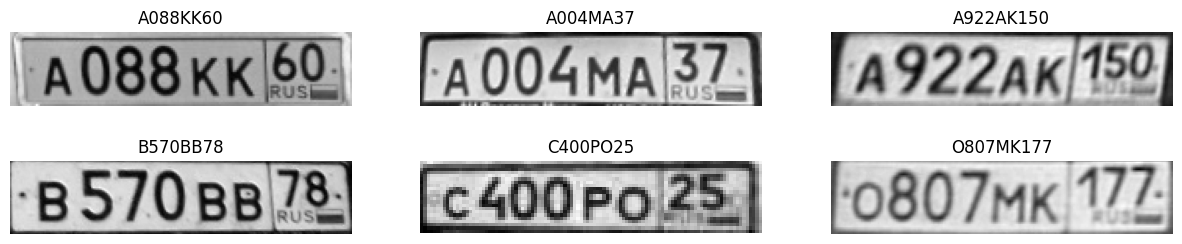

In [14]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:\\Users\\MSI_KATANA\\Desktop\\neuro\\autoriaNumberplateOcrRu-2021-09-01\\train\\img\\' + train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [15]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


In [16]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [17]:
train_size = 49382
valid_size= 4893

In [18]:
train_x = []

for i in range(train_size):
    img_dir = 'C:\\Users\\MSI_KATANA\\Desktop\\neuro\\autoriaNumberplateOcrRu-2021-09-01\\train\\img\\'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [19]:
valid_x = []

for i in range(valid_size):
    img_dir = 'C:\\Users\\MSI_KATANA\\Desktop\\neuro\\autoriaNumberplateOcrRu-2021-09-01\\val\\img\\'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [20]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [35]:
alphabets = u"ABEKMHOPCTEX1234567890"
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [37]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [-1  2  1  0 -1  9 -1 -1]


In [38]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [39]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [40]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  T874HH35 
train_y :  [ 9. 19. 18. 15.  5.  5. 14. 16. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [8.] 
train_input_len :  [62.]


In [41]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization_3 (Batc  (None, 256, 64, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                           

In [42]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [43]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [44]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

Epoch 1/60


InvalidArgumentError: Graph execution error:

Detected at node 'model_3/ctc/CTCLoss' defined at (most recent call last):
    File "C:\Users\MSI_KATANA\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\MSI_KATANA\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\MSI_KATANA\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Users\MSI_KATANA\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Users\MSI_KATANA\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\MSI_KATANA\AppData\Local\Temp\ipykernel_5844\213400110.py", line 4, in <module>
      model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\layers\core\lambda_layer.py", line 208, in call
      result = self.function(inputs, **kwargs)
    File "C:\Users\MSI_KATANA\AppData\Local\Temp\ipykernel_5844\496030596.py", line 7, in ctc_lambda_func
      return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
    File "c:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\.venv\lib\site-packages\keras\backend.py", line 7020, in ctc_batch_cost
      tf.compat.v1.nn.ctc_loss(
Node: 'model_3/ctc/CTCLoss'
All labels must be nonnegative integers, batch: 5 labels: 8,18,18,12,-1,6,14,12
	 [[{{node model_3/ctc/CTCLoss}}]] [Op:__inference_train_function_28061]

In [45]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

153/153 [==============================] - 32s 207ms/step


In [46]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 0.89%
Correct words predicted      : 0.00%


In [47]:
# Путь к папке с JSON файлами
json_folder = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\test\ann'

# Путь к выходному CSV файлу
csv_file = r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\test.csv'

# Создаем CSV файл и записываем заголовки
with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['FILENAME', 'IDENTITY']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=',')  # Добавлен delimiter=','
    writer.writeheader()

    # Перебираем JSON файлы в папке
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as jsonfile:
                data = json.load(jsonfile)
                # Записываем данные в CSV файл
                writer.writerow({
                    'FILENAME': data['name'] + '.png',
                    'IDENTITY': data['description']
                })

1/1 [==============================] - 0s 27ms/step


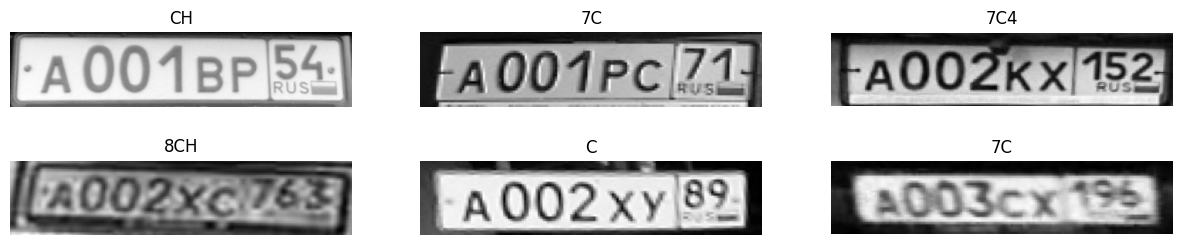

In [48]:
test = pd.read_csv(r'C:\Users\MSI_KATANA\Desktop\neuro\autoriaNumberplateOcrRu-2021-09-01\test.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'C:\\Users\\MSI_KATANA\\Desktop\\neuro\\autoriaNumberplateOcrRu-2021-09-01\\test\\img\\'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)